# Data Project from Uber - Solution

## Data Exploration 

Read the dataset and observe the columns as in the overview.


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/uber-challenge-00.csv")
df.head(10)

,Date,Time (Local),Eyeballs,Zeroes,Completed Trips,Requests,Unique Drivers
0,10-Sep-12,7,5,0,2,2,9
1,NaN,8,6,0,2,2,14
2,NaN,9,8,3,0,0,14
3,NaN,10,9,2,0,1,14
4,NaN,11,11,1,4,4,11
5,NaN,12,12,0,2,2,11
6,NaN,13,9,1,0,0,9
7,NaN,14,12,1,0,0,9
8,NaN,15,11,2,1,2,7
9,NaN,16,11,2,3,4,6


Date	   Time (Local)	Eyeballs	Zeroes	Completed Trips	Requests	Unique Drivers

2012-09-10	 16	         11	         2	        3	        4            6

This means that during the hour beginning at 4pm (hour 16), on September 10th, 2012, 11 people opened the Uber app (Eyeballs). 2 of them did not see any car (Zeroes) and 4 of them requested a car (Requests). Of the 4 requests, only 3 complete trips actually resulted (Completed Trips). During this time, there were a total of 6 drivers who logged in (Unique Drivers).


# date preprocessing

In [3]:
df.columns

Index(['Date', 'Time (Local)', 'Eyeballs ', 'Zeroes ', 'Completed Trips ',
       'Requests ', 'Unique Drivers'],
      dtype='object')

In [4]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)
df.columns

Index(['date', 'time_(local)', 'eyeballs', 'zeroes', 'completed_trips',
       'requests', 'unique_drivers'],
      dtype='object')

# fix critique des dates 
ffill() = forward fill
recopie la dernière date connue vers le bas
reconstruit les 24 heures par jour

In [5]:
df["date"] = df["date"].ffill()

In [6]:
df["date"] = pd.to_datetime(df["date"], format="%d-%b-%y")
df["datetime"] = df["date"] + pd.to_timedelta(df["time_(local)"], unit="h")
df["hour"] = df["time_(local)"]
df["weekday"] = df["datetime"].dt.weekday  # Monday=0

In [7]:
df["datetime"].isna().sum()
# → 0

np.int64(0)

In [8]:
df.groupby("date").size().head()

date
2012-09-10    17
2012-09-11    24
2012-09-12    24
2012-09-13    24
2012-09-14    24
dtype: int64

In [9]:
df["datetime"].isna().sum()
# → 0

np.int64(0)

## Question 1 

**Which date had the most completed trips during the two week period?**


In [10]:
trips_per_day = (
    df.groupby("date", as_index=False)
      .agg({"completed_trips": "sum"})
)

trips_per_day.loc[trips_per_day["completed_trips"].idxmax()]
#trips_per_day["completed_trips"] renvoie pandas.Series 
# puis indexmax() renvoie l'index de la ligne où completed_trips est maximum
# ensuite loc[] permet de récupérer la ligne correspondante à cet index
# 

date               2012-09-22 00:00:00
completed_trips                    248
Name: 12, dtype: object

## Question 2 

**What was the highest number of completed trips within a 24 hour
period?**
fenêtre glissante de 24h, pas nombre max journalier

In [11]:
# trions les données par date 
df = df.sort_values("datetime").reset_index(drop=True)
df.head()

,date,time_(local),eyeballs,zeroes,completed_trips,requests,unique_drivers,datetime,hour,weekday
0,2012-09-10,7,5,0,2,2,9,2012-09-10 07:00:00,7,0
1,2012-09-10,8,6,0,2,2,14,2012-09-10 08:00:00,8,0
2,2012-09-10,9,8,3,0,0,14,2012-09-10 09:00:00,9,0
3,2012-09-10,10,9,2,0,1,14,2012-09-10 10:00:00,10,0
4,2012-09-10,11,11,1,4,4,11,2012-09-10 11:00:00,11,0


# rolling window sur 24h 

In [12]:
df["completed_trips_24h"] = (
    df["completed_trips"]
    .rolling(window=24, min_periods=24)
    .sum()
)

# on identifie le maximum

In [13]:
idx_max = df["completed_trips_24h"].idxmax()
max_24h_trips = df.loc[idx_max, "completed_trips_24h"]

In [14]:
df.loc[idx_max]

date                   2012-09-22 00:00:00
time_(local)                            16
eyeballs                                58
zeroes                                  17
completed_trips                         15
requests                                18
unique_drivers                          16
datetime               2012-09-22 16:00:00
hour                                    16
weekday                                  5
completed_trips_24h                  278.0
Name: 297, dtype: object

In [15]:
df["datetime"].isna().sum()

np.int64(0)

In [16]:
df.groupby("date").size().head()

date
2012-09-10    17
2012-09-11    24
2012-09-12    24
2012-09-13    24
2012-09-14    24
dtype: int64

# intervalle temporel correspondant

In [17]:
start_time = df.loc[idx_max - 23, "datetime"]
end_time = df.loc[idx_max, "datetime"]

In [18]:
print("Highest number of completed trips in any 24-hour period:", max_24h_trips)
print("Time interval:", start_time, "→", end_time)

Highest number of completed trips in any 24-hour period: 278.0
Time interval: 2012-09-21 17:00:00 → 2012-09-22 16:00:00


## Question 3 

**Which hour of the day had the most requests during the two week
period?**


In [19]:
# total des requests par heure sur toute la période
requests_per_hour = (
    df.groupby("hour", as_index=False)
      .agg({"requests": "sum"})
)

# heure avec le maximum de requests
requests_per_hour.loc[requests_per_hour["requests"].idxmax()]

hour         23
requests    184
Name: 23, dtype: int64

## Question 4 

**What percentages of all zeroes (frustration utilisateur (pas de voiture)) during the two week period occurred on
weekend (Friday at 5 pm to Sunday at 3 am)?**

**Tip**: The local time value is the start of the hour (e.g. `15` is the
hour from 3:00pm - 4:00pm)
HINT
Tip: The local time value is the start of the hour (e.g. 15 is the hour from 3:00pm - 4:00pm)

In [58]:
weekend_mask = (
    # Vendredi (weekday = 4) à partir de 17h
    ((df["weekday"] == 4) & (df["hour"] >= 17))
    |
    # Samedi entier
    (df["weekday"] == 5)
    |
    # Dimanche jusqu’à 3h du matin (hour = 0,1,2)
    ((df["weekday"] == 6) & (df["hour"] <= 2))
)

In [59]:
total_zeroes = df["zeroes"].sum()
weekend_zeroes = df.loc[weekend_mask, "zeroes"].sum()

percentage_weekend_zeroes = weekend_zeroes / total_zeroes * 100
percentage_weekend_zeroes

np.float64(44.856543037088876)

## Question 5 

**What is the weighted average ratio of completed trips per driver
during the two week period?**

**Tip**: "Weighted average" means your answer should account for the
total trip volume in each hour to determine the most accurate number in
whole period.


Ce n’est PAS :
la moyenne des ratios horaires : mean(completed_trips / unique_drivers) 

Pourquoi ?
Parce qu’une heure calme pèserait autant qu’une heure très chargée.

Formule correcte (pondérée)

La pondération se fait par le volume réel de trips.

La formule devient simplement :

Weighted average = ∑(completed trips)/∑(unique drivers)

Chaque heure contribue proportionnellement à son activité réelle

In [22]:
total_completed_trips = df["completed_trips"].sum()
total_unique_drivers = df["unique_drivers"].sum()

weighted_avg_trips_per_driver = total_completed_trips / total_unique_drivers
weighted_avg_trips_per_driver

np.float64(0.5145118733509235)

## Question 6 

**In drafting a driver schedule in terms of 8 hours shifts, when are the
busiest 8 consecutive hours over the two week period in terms of unique
requests? A new shift starts in every 8 hours. Assume that a driver will
work same shift each day.**

Using rolling 8-hour time windows (e.g. with `resample('8H')`) would
break daily shift alignment across days.  
Instead, we assign each row to one of three fixed shift blocks: 0–7,
8–15, and 16–23, based on the hour of the day.

First, we clean column names in case of trailing spaces:


In [23]:
df["shift_8h"] = (df["hour"] // 8) * 8
# On obtient le numéro du shift après la division entière de l’heure par 8, 
# puis on multiplie par 8 pour obtenir l’heure de début du shift:

# 0 → 1er shift

# 1 → 2e shift

# 2 → 3e shift

| hour | hour // 8 | × 8 | shift_8h |
| ---- | --------- | --- | -------- |
| 0    | 0         | 0   | 0        |
| 6    | 0         | 0   | 0        |
| 7    | 0         | 0   | 0        |
| 8    | 1         | 8   | 8        |
| 14   | 1         | 8   | 8        |
| 15   | 1         | 8   | 8        |
| 16   | 2         | 16  | 16       |
| 22   | 2         | 16  | 16       |
| 23   | 2         | 16  | 16       |


In [24]:
shift_requests = (
    df.groupby("shift_8h", as_index=False)
      .agg({"requests": "sum"})
)

In [25]:
shift_requests.loc[shift_requests["requests"].idxmax()]

shift_8h      16
requests    1032
Name: 2, dtype: int64

In [26]:
df["shift"] = df["hour"] // 8

busiest_shift = (
    df.groupby("shift")["requests"]
      .sum()
      .idxmax()
)

shift_map = {
    0: "00:00–08:00",
    1: "08:00–16:00",
    2: "16:00–00:00"
}

print("Busiest shift:", shift_map[busiest_shift])

Busiest shift: 16:00–00:00


## Question 7 

**True or False: Driver supply always increases when demand increases
during the two week period.**

<Note type="tip">

Visualize the data to confirm your answer if needed.

</Note>


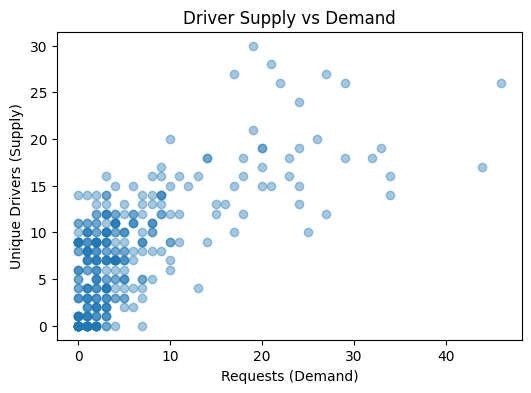

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(df["requests"], df["unique_drivers"], alpha=0.4)
plt.xlabel("Requests (Demand)")
plt.ylabel("Unique Drivers (Supply)")
plt.title("Driver Supply vs Demand")
plt.show()

In [28]:
df_sorted = df.sort_values("datetime")

counter_examples = df_sorted[
    (df_sorted["requests"].diff() > 0) &
    (df_sorted["unique_drivers"].diff() <= 0)
]
# On garde les lignes où :
# la demande augmente
# ET l’offre n’augmente pas


counter_examples.head()

,date,time_(local),eyeballs,zeroes,completed_trips,requests,unique_drivers,datetime,hour,weekday,completed_trips_24h,shift_8h,shift
3,2012-09-10,10,9,2,0,1,14,2012-09-10 10:00:00,10,0,NaN,8,1
4,2012-09-10,11,11,1,4,4,11,2012-09-10 11:00:00,11,0,NaN,8,1
8,2012-09-10,15,11,2,1,2,7,2012-09-10 15:00:00,15,0,NaN,8,1
9,2012-09-10,16,11,2,3,4,6,2012-09-10 16:00:00,16,0,NaN,16,2
14,2012-09-10,21,11,0,1,1,3,2012-09-10 21:00:00,21,0,NaN,16,2


While supply generally follows demand, there are multiple instances where demand increases without a corresponding increase in active drivers, indicating supply frictions.

## Question 8 

**In which 72 hour period is the ratio of Zeroes to Eyeballs the
highest?**


In [29]:
df_sorted = df.sort_values("datetime").reset_index(drop=True)

In [30]:
df_sorted["zeroes_72h"] = df_sorted["zeroes"].rolling(window=72).sum()
df_sorted["eyeballs_72h"] = df_sorted["eyeballs"].rolling(window=72).sum()

In [31]:
df_sorted["zeroes_to_eyeballs_72h"] = (
    df_sorted["zeroes_72h"] / df_sorted["eyeballs_72h"]
)

In [32]:
idx_max = df_sorted["zeroes_to_eyeballs_72h"].idxmax()

start_time = df_sorted.loc[idx_max - 71, "datetime"]
end_time = df_sorted.loc[idx_max, "datetime"]
max_ratio = df_sorted.loc[idx_max, "zeroes_to_eyeballs_72h"]

start_time, end_time, max_ratio

(Timestamp('2012-09-15 05:00:00'),
 Timestamp('2012-09-18 04:00:00'),
 np.float64(0.2929765886287625))

## Question 9 

**If you could add 5 drivers to any single hour of every day during the
two week period, which hour should you add them to?**

<Note type="hint">

Consider both rider eyeballs and driver supply when choosing

</Note>

In [33]:
df_valid = df[df["unique_drivers"] > 0].copy()

df_valid["eyeballs_per_driver"] = (
    df_valid["eyeballs"] / df_valid["unique_drivers"]
)

In [34]:
hourly_pressure = (
    df_valid
    .groupby("hour")["eyeballs_per_driver"]
    .mean()
    .sort_values(ascending=False)
)

In [35]:
best_hour = hourly_pressure.idxmax()
best_hour, hourly_pressure.loc[best_hour]

(np.int64(23), np.float64(4.8911190117072465))

## Question 10 

**True or False: There is exactly two weeks of data in this analysis**


In [36]:
df["datetime"].min(), df["datetime"].max()

(Timestamp('2012-09-10 07:00:00'), Timestamp('2012-09-24 06:00:00'))

In [37]:
df["datetime"].max() - df["datetime"].min()

Timedelta('13 days 23:00:00')

In [38]:
df.shape[0]

336

There is not exactly two weeks of data.
Although the dataset contains 336 hourly records, it spans 13 days and 23 hours, not a full 14-day period.

## Question 11 

**Looking at the data from all two weeks, which time might make the most
sense to consider a true "end day" instead of midnight? (i.e when are
supply and demand at both their natural minimums)**

<Note type="tip">

Visualize the data to confirm your answer if needed.
</Note>

In [42]:
hourly_avg= (df.groupby("hour")[["requests", "unique_drivers"]].mean())
hourly_avg

,requests,unique_drivers
hour,,
0,10.142857,7.928571
1,6.857143,6.714286
2,7.142857,4.428571
3,2.500000,2.857143
4,0.642857,0.642857
5,1.000000,0.785714
6,2.000000,2.642857
7,1.571429,4.285714
8,2.071429,6.785714


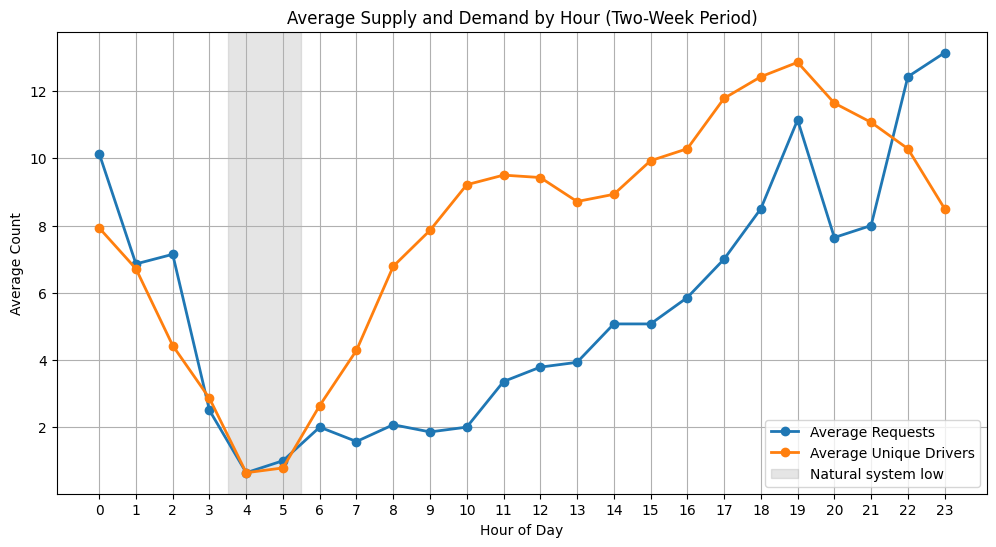

In [43]:
import matplotlib.pyplot as plt

# Moyennes par heure sur les deux semaines

plt.figure(figsize=(12,6))

plt.plot(
    hourly_avg.index,
    hourly_avg["requests"],
    marker="o",
    label="Average Requests",
    linewidth=2
)

plt.plot(
    hourly_avg.index,
    hourly_avg["unique_drivers"],
    marker="o",
    label="Average Unique Drivers",
    linewidth=2
)

# Zone du minimum naturel (≈ 4–5h)
plt.axvspan(3.5, 5.5, color="grey", alpha=0.2, label="Natural system low")

plt.title("Average Supply and Demand by Hour (Two-Week Period)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Count")
plt.xticks(range(24))
plt.legend()
plt.grid(True)

plt.show()